![](https://web.archive.org/web/20161019192412im_/http://lisp.vse.cz/pkdd99/data.gif)

[Guide to the Financial Data Set](https://web.archive.org/web/20161019192412/http://lisp.vse.cz/pkdd99/berka.htm)
    
[1999 Czech Financial Dataset - Real Anonymized Transactions](https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions)

In [298]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier 
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.features.importances import FeatureImportances
from xgboost import XGBClassifier

In [2]:
district_df = pd.read_csv('berka/district.csv', delimiter= ";", 
                          names = ["district code", "district name", "region", "no. of inhabitants", 
                          "no. of municipalities with inhabitants < 499", 
                          "no. of municipalities with inhabitants 500-1999", 
                          "no. of municipalities with inhabitants 2000-9999",
                          "no. of municipalities with inhabitants >10000", 
                          "no. of cities", "ratio of urban inhabitants" , "average salary",
                          "unemploymant rate 95", "unemploymant rate 96", 
                          "no. of enterpreneurs per 1000 inhabitants", "no. of commited crimes 95",
                          "no. of commited crimes 96"], )

In [3]:
district_df = district_df.drop(0, axis = 0)
district_df.head()

,district code,district name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate 95,unemploymant rate 96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes 95,no. of commited crimes 96
1,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
2,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
3,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
4,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
5,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [4]:
district_df.shape

(77, 16)

In [5]:
district_df['district code'] = district_df['district code'].astype(int)

In [6]:
account_df = pd.read_csv('berka/account.csv', delimiter=';')

In [7]:
account_df.head()

,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,930101
1,3818,74,POPLATEK MESICNE,930101
2,704,55,POPLATEK MESICNE,930101
3,2378,16,POPLATEK MESICNE,930101
4,2632,24,POPLATEK MESICNE,930102


In [8]:
client_df = pd.read_csv('berka/client.csv', delimiter=';')

In [9]:
client_df.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [10]:
card_df = pd.read_csv('berka/card.csv', delimiter=';')

In [11]:
card_df.head()

,card_id,disp_id,type,issued
0,1005,9285,classic,931107 00:00:00
1,104,588,classic,940119 00:00:00
2,747,4915,classic,940205 00:00:00
3,70,439,classic,940208 00:00:00
4,577,3687,classic,940215 00:00:00


In [12]:
disp_df = pd.read_csv('berka/disp.csv', delimiter=';')

In [13]:
disp_df.head()

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [14]:
loan_df = pd.read_csv('berka/loan.csv', delimiter=';')

In [15]:
loan_df.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033.0,B
1,5316,1801,930711,165960,36,4610.0,A
2,6863,9188,930728,127080,60,2118.0,A
3,5325,1843,930803,105804,36,2939.0,A
4,7240,11013,930906,274740,60,4579.0,A


In [16]:
order_df = pd.read_csv('berka/order.csv', delimiter=';')

In [17]:
order_df.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,


In [18]:
trans_df = pd.read_csv('berka/trans.csv', delimiter=';')

/home/m/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
trans_df.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


In [20]:
df1 = pd.merge(account_df, loan_df, left_on='account_id', right_on='account_id', how='inner')
df2 = pd.merge(account_df, order_df, left_on='account_id', right_on='account_id', how='inner')
df3 = pd.merge(account_df, trans_df, left_on='account_id', right_on='account_id', how='inner')
df4 = pd.merge(account_df, district_df, left_on='district_id', right_on='district code', how='inner')
df5 = pd.merge(account_df, disp_df, left_on='account_id', right_on='account_id', how='inner')
df = pd.merge(disp_df, card_df, left_on='disp_id', right_on='disp_id', how='inner')
df6 = pd.merge(account_df, df, left_on='account_id', right_on='account_id', how='inner')
df = pd.merge(disp_df, client_df, left_on='client_id', right_on='client_id', how='inner')
df7 = pd.merge(account_df, df, left_on='account_id', right_on='account_id', how='inner')

In [21]:
from functools import reduce

In [22]:
dfs = [df1, df2, df3, df4, df5, df6, df7]

In [23]:
dataframe = reduce(lambda left,right: pd.merge(left, right, on = "account_id"), dfs)

In [24]:
data = dataframe[['account_id', 'loan_id', 'duration', 'payments', 'status', 'order_id', 'bank_to', 'account_to', 'trans_id', 'operation', 'amount', 'balance', 'bank', 'account', 'district code', 'district name', 'region', 'no. of inhabitants', 'no. of municipalities with inhabitants < 499', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999', 'no. of municipalities with inhabitants >10000', 'no. of cities', 'ratio of urban inhabitants', 'average salary', 'unemploymant rate 95', 'unemploymant rate 96', 'no. of enterpreneurs per 1000 inhabitants', 'no. of commited crimes 95', 'no. of commited crimes 96', 'card_id', 'issued', 'frequency', 'date', 'disp_id', 'client_id', 'type', 'birth_number']]
data.head()

,account_id,loan_id,duration,payments,status,order_id,bank_to,account_to,trans_id,operation,...,no. of commited crimes 95,no. of commited crimes 96,card_id,issued,frequency,date,disp_id,client_id,type,birth_number
0,5891,6202,12,5432.0,A,38118,EF,95617645,1736607,VKLAD,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
1,5891,6202,12,5432.0,A,38118,EF,95617645,1736609,PREVOD Z UCTU,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
2,5891,6202,12,5432.0,A,38118,EF,95617645,1736950,VYBER,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
3,5891,6202,12,5432.0,A,38118,EF,95617645,3673340,NaN,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
4,5891,6202,12,5432.0,A,38118,EF,95617645,1736610,PREVOD Z UCTU,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929


In [25]:
data.shape

(174249, 38)

In [26]:
data.isna().sum()

account_id                                               0
loan_id                                                  0
duration                                                 0
payments                                                 0
status                                                   0
order_id                                                 0
bank_to                                                  0
account_to                                               0
trans_id                                                 0
operation                                            24197
amount                                                   0
balance                                                  0
bank                                                120490
account                                             107567
district code                                            0
district name                                            0
region                                                  

In [27]:
# Let's drop the columns with missing data

In [28]:
data = data.drop(['operation', 'bank', 'account'], axis = 1)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174249 entries, 0 to 174248
Data columns (total 35 columns):
account_id                                          174249 non-null int64
loan_id                                             174249 non-null int64
duration                                            174249 non-null int64
payments                                            174249 non-null float64
status                                              174249 non-null object
order_id                                            174249 non-null int64
bank_to                                             174249 non-null object
account_to                                          174249 non-null int64
trans_id                                            174249 non-null int64
amount                                              174249 non-null float64
balance                                             174249 non-null float64
district code                                       174249 non-null

In [30]:
data = data.replace('?', np.nan)

In [31]:
data.isna().sum()

account_id                                             0
loan_id                                                0
duration                                               0
payments                                               0
status                                                 0
order_id                                               0
bank_to                                                0
account_to                                             0
trans_id                                               0
amount                                                 0
balance                                                0
district code                                          0
district name                                          0
region                                                 0
no. of inhabitants                                     0
no. of municipalities with inhabitants < 499           0
no. of municipalities with inhabitants 500-1999        0
no. of municipalities with inha

In [46]:
data[['account_id', 'loan_id', 'duration', 'status', 'order_id', 'bank_to', 'account_to', 'trans_id', 'district code', 'district name', 'region', 'card_id', 'issued', 'frequency', 'date', 'disp_id', 'client_id', 'type', 'birth_number']] = data[['account_id', 'loan_id', 'duration', 'status', 'order_id', 'bank_to', 'account_to', 'trans_id', 'district code', 'district name', 'region', 'card_id', 'issued', 'frequency', 'date', 'disp_id', 'client_id', 'type', 'birth_number']].astype(object)

In [45]:
data[['payments', 'amount', 'balance', 'ratio of urban inhabitants', 'average salary', 'unemploymant rate 95', 'unemploymant rate 96', 'no. of commited crimes 95', 'no. of commited crimes 96']] = data[['payments', 'amount', 'balance', 'ratio of urban inhabitants', 'average salary', 'unemploymant rate 95', 'unemploymant rate 96', 'no. of commited crimes 95', 'no. of commited crimes 96']].astype(float)

In [44]:
data[['no. of inhabitants', 'no. of municipalities with inhabitants < 499', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999', 'no. of municipalities with inhabitants >10000', 'no. of cities']] = data[['no. of inhabitants', 'no. of municipalities with inhabitants < 499', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999', 'no. of municipalities with inhabitants >10000', 'no. of cities']].astype(int)

In [47]:
data["unemploymant rate 95"] = data["unemploymant rate 95"].fillna(np.mean(data["unemploymant rate 95"]))
data['no. of commited crimes 95'] = data['no. of commited crimes 95'].fillna(np.mean(data['no. of commited crimes 95']))

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174249 entries, 0 to 174248
Data columns (total 35 columns):
account_id                                          174249 non-null object
loan_id                                             174249 non-null object
duration                                            174249 non-null object
payments                                            174249 non-null float64
status                                              174249 non-null object
order_id                                            174249 non-null object
bank_to                                             174249 non-null object
account_to                                          174249 non-null object
trans_id                                            174249 non-null object
amount                                              174249 non-null float64
balance                                             174249 non-null float64
district code                                       174249 no

In [49]:
data_num = data.select_dtypes(exclude = ['object'])
data_cat = data.select_dtypes(include = ['object'])

In [50]:
data_cat.shape, data_num.shape

((174249, 20), (174249, 15))

In [51]:
data_num.head()

,payments,amount,balance,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate 95,unemploymant rate 96,no. of commited crimes 95,no. of commited crimes 96
0,5432.0,900.0,900.0,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,18721.0,18696.0
1,5432.0,32594.0,33494.0,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,18721.0,18696.0
2,5432.0,4500.0,28994.0,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,18721.0,18696.0
3,5432.0,21.6,29015.6,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,18721.0,18696.0
4,5432.0,32594.0,61609.6,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,18721.0,18696.0


In [52]:
data_cat.head()

,account_id,loan_id,duration,status,order_id,bank_to,account_to,trans_id,district code,district name,region,no. of enterpreneurs per 1000 inhabitants,card_id,issued,frequency,date,disp_id,client_id,type,birth_number
0,5891,6202,12,A,38118,EF,95617645,1736607,54,Brno - mesto,south Moravia,140,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
1,5891,6202,12,A,38118,EF,95617645,1736609,54,Brno - mesto,south Moravia,140,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
2,5891,6202,12,A,38118,EF,95617645,1736950,54,Brno - mesto,south Moravia,140,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
3,5891,6202,12,A,38118,EF,95617645,3673340,54,Brno - mesto,south Moravia,140,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
4,5891,6202,12,A,38118,EF,95617645,1736610,54,Brno - mesto,south Moravia,140,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929


In [80]:
data_cat.duration.value_counts()

12    55188
60    36052
24    29432
48    28378
36    25199
Name: duration, dtype: int64

In [54]:
data_cat.type.value_counts()

OWNER        128019
DISPONENT     46230
Name: type, dtype: int64

In [55]:
data_cat.status.value_counts()

C    87493
A    83278
B     2526
D      952
Name: status, dtype: int64

In [56]:
data_cat.frequency.value_counts()

POPLATEK MESICNE      153477
POPLATEK TYDNE         16717
POPLATEK PO OBRATU      4055
Name: frequency, dtype: int64

In [93]:
def check_value_counts(x):
    return len(x.value_counts())

In [94]:
data_cat.apply(lambda x: check_value_counts(x))

account_id                                     170
loan_id                                        170
duration                                         5
status                                           4
order_id                                       354
bank_to                                         13
account_to                                     351
trans_id                                     47127
district code                                   60
district name                                   60
region                                           8
no. of enterpreneurs per 1000 inhabitants       36
card_id                                        170
issued                                         160
frequency                                        3
date                                           162
disp_id                                        206
client_id                                      206
type                                             2
birth_number                   

In [104]:
data_cat_dum = pd.get_dummies(data_cat[['duration', 'status', 'bank_to', 'region','frequency','type']])

In [163]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [164]:
data_num_sca = scaler.fit_transform(data_num)

/home/m/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/m/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [169]:
data_num_sca = pd.DataFrame(data_num_sca, index = data_num.index, columns = data_num.columns)

In [170]:
data_new = pd.concat([data_cat_dum, data_num_sca], axis = 1)

In [171]:
data_new.shape

(174249, 50)

In [74]:
pd.DataFrame((np.random.random(len(data)) < .05).astype(int))[0].value_counts()

0    165637
1      8612
Name: 0, dtype: int64

In [172]:
from sklearn.decomposition import PCA

In [173]:
pca = PCA()
pca.fit(data_new)
features = range(pca.n_components_)

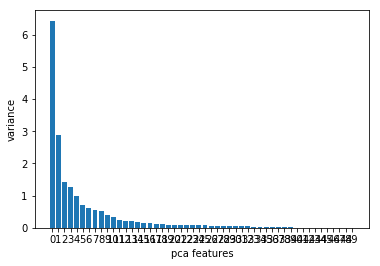

In [174]:
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('pca features')
plt.show()

In [175]:
pca = PCA(n_components = 2).fit(data_new)

In [176]:
data_new_pca = pca.transform(data_new)

In [197]:
data_new_pca

array([[ 2.71351876,  0.18095986],
       [ 2.66727558,  0.3644975 ],
       [ 2.68302506,  0.26666738],
       ...,
       [-1.03763393,  2.38163657],
       [-1.09338996,  2.59792743],
       [-1.07778887,  2.47609954]])

In [198]:
from sklearn.cluster import KMeans

In [248]:
kmeans = KMeans(n_clusters = 10)

In [249]:
kmeans.fit(data_new_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [250]:
labels = kmeans.predict(data_new_pca)

In [251]:
labels

array([7, 7, 7, ..., 4, 4, 4], dtype=int32)

In [252]:
pd.DataFrame(labels)[0].value_counts()

5    48676
3    26270
2    17456
8    17273
4    16543
0    15832
9    12549
1    12461
7     3725
6     3464
Name: 0, dtype: int64

In [253]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


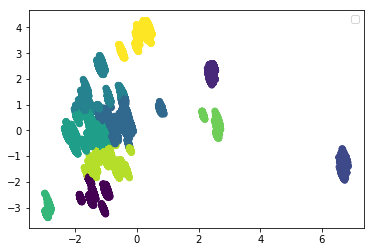

In [254]:
plt.scatter(x =(data_new_pca)[:,0], y = (data_new_pca)[:,1], marker = 'o', c = labels)
plt.legend()
plt.show()

In [255]:
to_plot = pd.concat([pd.DataFrame(data_new_pca, columns= ['x', 'y']), pd.DataFrame(labels, columns= ['label'])], axis = 1)# 

In [256]:
import seaborn as sns

/home/m/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


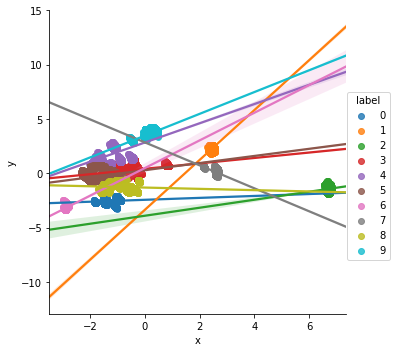

In [257]:
sns.lmplot(data = to_plot, x = 'x', y = 'y', hue = 'label' , legend = True)
plt.show()

In [264]:
sb = pd.DataFrame(labels, columns= ['label'])

In [265]:
sb['flag'] = 0

In [268]:
sb.flag[sb.label == 6] = 1

/home/m/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [270]:
sb.flag.value_counts()

0    170785
1      3464
Name: flag, dtype: int64

In [271]:
## let's do classification

In [279]:
data_new_sb = pd.concat([data_new, sb.flag], axis= 1)
data_new_pca_sb = pd.concat([pd.DataFrame(data_new_pca), sb.flag], axis= 1)

In [281]:
X = data_new_sb.drop('flag', axis = 1)
y = data_new_sb.flag

X_pca = data_new_pca_sb.drop('flag', axis = 1)
y_pca = data_new_pca_sb.flag

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size = 0.2, random_state = 1)

In [ ]:
#using model_fit for the regular dataset with all columns of data

In [292]:
def model_fit(x):
    x.fit(X_train, y_train)
    y_pred = x.predict(X_test)
    model_fit.accuracy = accuracy_score(y_pred, y_test)
    print('Accuracy Score',accuracy_score(y_pred, y_test))
    print(classification_report(y_pred, y_test))
    print('Confusion Matrix \n',confusion_matrix(y_pred, y_test))
    

In [293]:
model_fit(KNeighborsClassifier(n_neighbors = 4))
KNN = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34181
           1       1.00      1.00      1.00       669

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34181     0]
 [    0   669]]


In [287]:
from sklearn.linear_model import LogisticRegression
model_fit(LogisticRegression())
Logistic = model_fit.accuracy

/home/m/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34181
           1       1.00      1.00      1.00       669

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850



In [294]:
from sklearn.naive_bayes import GaussianNB
model_fit(GaussianNB())
Gaussian = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34181
           1       1.00      1.00      1.00       669

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34181     0]
 [    0   669]]


In [295]:
from sklearn import tree
model_fit(tree.DecisionTreeClassifier())
Tree = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34181
           1       1.00      1.00      1.00       669

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34181     0]
 [    0   669]]


In [296]:
from sklearn.ensemble import RandomForestClassifier
model_fit(RandomForestClassifier(n_estimators = 100, max_depth =10, random_state = 1))
RandomForest = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34181
           1       1.00      1.00      1.00       669

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34181     0]
 [    0   669]]


In [320]:
m = RandomForestClassifier().fit(X_train, y_train)

/home/m/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


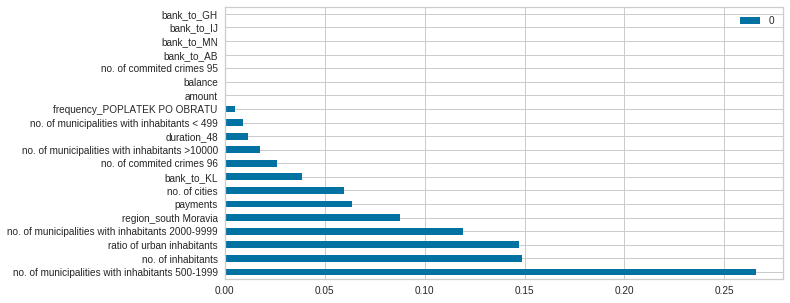

In [321]:
x = pd.DataFrame(m.feature_importances_, X_train.columns)
pd.DataFrame(x[0].sort_values(ascending = False)[0:20]).iloc[:,:1].plot.barh(figsize=(10,5))
plt.show()

In [304]:
scores_list_1 = ['KNN','Logistic','Gaussian','Tree','RandomForest']
scores_1 = [KNN, Logistic, Gaussian, Tree, RandomForest, ]

In [305]:
score_df_classification = pd.DataFrame([scores_list_1, scores_1]).T

In [306]:
score_df_classification.index = score_df_classification[0]
del score_df_classification[0]
score_df_classification

,1
0,
KNN,1
Logistic,1
Gaussian,1
Tree,1
RandomForest,1


In [ ]:
#using model_fit for the pca dataset with all columns of data

In [309]:
def model_fit(x):
    x.fit(X_train_pca, y_train_pca)
    y_pred = x.predict(X_test_pca)
    model_fit.accuracy = accuracy_score(y_pred, y_test_pca)
    print('Accuracy Score',accuracy_score(y_pred, y_test_pca))
    print(classification_report(y_pred, y_test_pca))
    print('Confusion Matrix \n',confusion_matrix(y_pred, y_test_pca))

In [310]:
model_fit(KNeighborsClassifier(n_neighbors = 4))
KNN = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34181
           1       1.00      1.00      1.00       669

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34181     0]
 [    0   669]]


In [311]:
model_fit(LogisticRegression())
Logistic = model_fit.accuracy

/home/m/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34181
           1       1.00      1.00      1.00       669

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34181     0]
 [    0   669]]


In [312]:
model_fit(GaussianNB())
Gaussian = model_fit.accuracy

Accuracy Score 0.9989670014347203
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34217
           1       0.95      1.00      0.97       633

   micro avg       1.00      1.00      1.00     34850
   macro avg       0.97      1.00      0.99     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34181    36]
 [    0   633]]


In [313]:
model_fit(tree.DecisionTreeClassifier())
Tree = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34181
           1       1.00      1.00      1.00       669

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34181     0]
 [    0   669]]


In [314]:
model_fit(RandomForestClassifier(n_estimators = 100, max_depth =10, random_state = 1))
RandomForest = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34181
           1       1.00      1.00      1.00       669

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34181     0]
 [    0   669]]


In [315]:
scores_list_1 = ['KNN','Logistic','Gaussian','Tree','RandomForest']
scores_1 = [KNN, Logistic, Gaussian, Tree, RandomForest, ]

In [316]:
score_df_classification = pd.DataFrame([scores_list_1, scores_1]).T

In [317]:
score_df_classification.index = score_df_classification[0]
del score_df_classification[0]
score_df_classification

,1
0,
KNN,1
Logistic,1
Gaussian,0.998967
Tree,1
RandomForest,1
